In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
from copy import deepcopy
from matplotlib import pyplot
from scipy import stats
import logging
import matplotlib
import matplotlib.gridspec as gridspec
import os
import pandas
import string, math, numpy
import sys, os, glob, csv, re
import subprocess

In [4]:
#pyplot.style.use('dark_background')
logging.basicConfig(level=logging.INFO)

In [5]:
try:
    from ltrack import config
    import ltrack.lineage.inference_params as inference_params
    import ltrack.lineage.file_parser as file_parser
    from ltrack.lineage.fitness_estimator import *
except ImportError:
    print("Please install the LineageTracking package by running the command line 'pip install .' in the lineage_tracking repository's root directory.")
    raise
except: raise

In [6]:
project_name = os.path.basename(os.getcwd())

In [7]:
population = project_name

In [8]:
barcode_lists = {}

In [9]:
#read data
timepoints, data, counts = file_parser.get_data(population, config.barcode_data_root_directory)
max_barcode = config.max_barcode[population]

INFO:root:Processing population LTtest.
INFO:root:Reading files.
INFO:root:Reading files complete.


In [10]:
#read kappas
kappas = file_parser.read_kappas_from_file(config.error_model_directory+population+'-kappas.tsv')

In [11]:
#loop through the different environments
environment = 'evolution'

In [12]:
#read empirical null distribution and q-values
empirical_null, t_statistic_95_percent_cutoff = file_parser.read_empirical_null_from_file(
                                                                        config.error_model_directory
                                                                        +population
                                                                        +'-empirical_null_%s.tsv'%environment)

In [13]:
qvals = file_parser.read_q_values_from_file(config.error_model_directory+population+'-q_values_%s.tsv'%environment)

In [14]:
#initialize fitness estimator object
fitness_estimator = FitnessEstimator(counts, kappas, 
                                        qvals = qvals,
                                        t_statistic_95_percent_cutoff = t_statistic_95_percent_cutoff,
                                        empirical_null = empirical_null
                                    )

In [15]:
barcoding = False

In [16]:
#estimate relative fitnesses
#ensure all lineage fitnesses are zero to start with
for dataset in range(0,max_barcode):
    for parent_id in data[dataset].keys():
        for bcd, lineage in data[dataset][parent_id].items():
            lineage.relative_fitness = np.zeros(len(lineage.freqs)//INTERVALS_PER_EPOCH)
            lineage.relative_fitness_CI = [(0,0) for i in range(0,len(lineage.relative_fitness))]

In [17]:
fitness_estimator.population_fitness = numpy.zeros(len(fitness_estimator.population_fitness))

In [18]:
for target_epoch in range(0,max_barcode-barcoding):
    logging.info("Target epoch is %d.", target_epoch)

    converged = False
    it = 0

    while not converged and it < 40:

        if it > 0:
            logging.info("re-estimating... (it = %d)", it + 1)
        it +=1

        converged = True

        for using_barcode in range(0,target_epoch+1):

            begin, end = fitness_estimator.get_interval_endpoints(target_epoch, barcoding = barcoding)
            max_mean_fitness =deepcopy(fitness_estimator.population_fitness[begin:end])

            for parent_id in data[using_barcode].keys():
                for bcd, lineage in data[using_barcode][parent_id].items():
                    fitness_estimator.update_lineage_fitness(lineage, target_epoch, barcoding = barcoding)

            fitness_estimator.update_mean_fitness(data[using_barcode], target_epoch, barcoding = barcoding)

            if fitness_estimator.population_fitness[end-1] > max_mean_fitness[-1] + 10**-6:
                converged = False
            else:
                fitness_estimator.population_fitness[begin:end] = max_mean_fitness

INFO:root:Target epoch is 0.
INFO:root:re-estimating... (it = 2)
INFO:root:re-estimating... (it = 3)
INFO:root:re-estimating... (it = 4)
INFO:root:re-estimating... (it = 5)
INFO:root:Target epoch is 1.
INFO:root:re-estimating... (it = 2)


In [19]:

barcode_lists.update({environment:[]})

In [20]:
for using_barcode in range(1,max_barcode+1):
    
    with open(config.lineage_fitness_estimate_directory+'%s-BC%d_%s_fitnesses.csv' % 
                                            (population,using_barcode,environment), 'w') as csvfile:
        out_writer = csv.writer(csvfile, delimiter='\t', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        out_writer.writerow(['BC'] + ['Epoch%d' % (d+1) for d in range(using_barcode-1,10)])

        for parent_id in data[using_barcode - 1].keys():
            for bcd, lineage in data[using_barcode - 1][parent_id].items():
                # if any(lineage.relative_fitness > 0):
                if True:
                    barcode_lists[environment].append(lineage.ID)

                    row = [lineage.ID]
                    fitnesses = numpy.zeros(3*len(lineage.relative_fitness))
                    fitnesses[::3] = lineage.relative_fitness
                    fitnesses[1::3] = [lower[0] for lower in lineage.relative_fitness_CI]
                    fitnesses[2::3] = [upper[1] for upper in lineage.relative_fitness_CI]
                    
                    row.extend(fitnesses.tolist())
                    
                    out_writer.writerow(row)
                    
logging.info('A total of %d barcodes in the __evolution__ environment have been found.', len(barcode_lists['evolution']))    

INFO:root:A total of 14444 barcodes in the __evolution__ environment have been found.


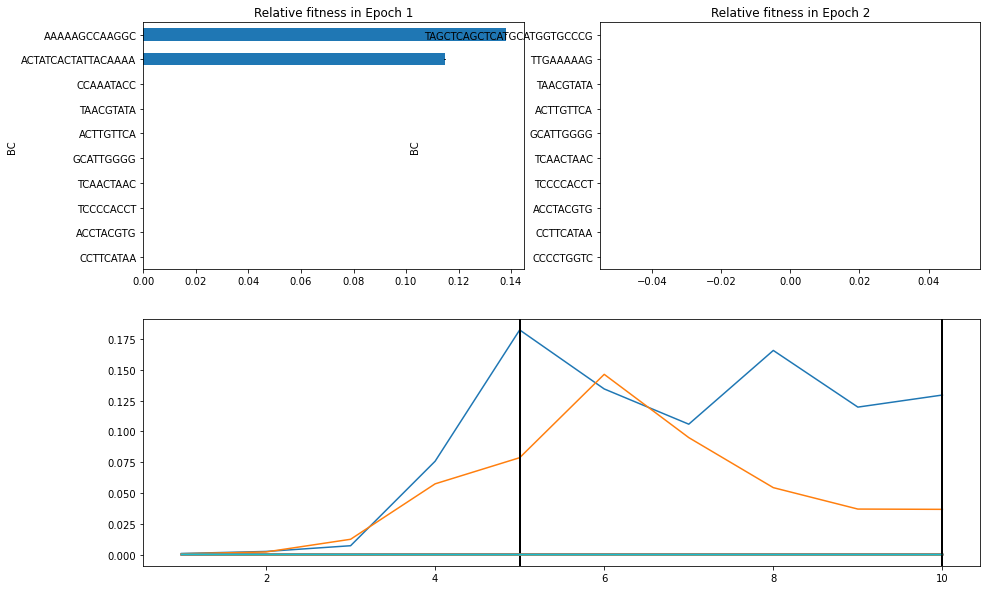

In [30]:
idx = pandas.IndexSlice
using_barcode=1
iterables = [["Epoch {0:d}".format(epoch) for epoch in range(using_barcode,max_barcode+1)],
             ["fitness_mean", "fitness_CI_min", "fitness_CI_max"]
            ]
columns = pandas.MultiIndex.from_product(iterables, names=['Epoch', 'fitness'])
fitnesses = pandas.read_csv(
    os.path.join(
        config.lineage_fitness_estimate_directory,'{}-BC{}_{}_fitnesses.csv'.format(
            population,
            using_barcode,
            'evolution'
        )
    ),
    sep='\t',
    index_col=0,
)
fitnesses.dropna(inplace=True, axis='columns')
fitnesses = fitnesses.iloc[:, :3*(max_barcode+1-using_barcode)]
fitnesses.columns = columns

for epoch in set(columns.get_level_values(level="Epoch")):
    fitnesses[(epoch, 'fitness_CI')] = fitnesses[(epoch, "fitness_CI_max")] - fitnesses[(epoch, "fitness_CI_min")]

fitnesses.sort_index(level="Epoch", inplace=True, axis=1)

fig, axs = pyplot.subplots(2,len(set(fitnesses.columns.get_level_values(level="Epoch"))), figsize=(15,10))
gridspec = axs[1,0].get_gridspec()
for ax in axs[1,:]:
    ax.remove()
joined_ax = fig.add_subplot(gridspec[1,:])  
max_freq = 0.0
epochs = sorted(set(fitnesses.columns.get_level_values(level="Epoch")))
colors=['r','b']
for iepoch,epoch in enumerate(epochs):
    tmp = fitnesses.loc[::-1,idx[epoch,["fitness_mean", "fitness_CI"]]]
    tmp.columns = tmp.columns.droplevel(level="Epoch")
    tmp.sort_values(by="fitness_mean",axis='index', ascending=False, inplace=True)
    tmp.head(10).iloc[::-1,:].plot.barh(ax=axs[0,iepoch],
                  y="fitness_mean",
                  yerr="fitness_CI",
                  legend=False,
                  title="Relative fitness in {}".format(epoch),
                 )

    top10 = [list(data[0].values())[0][bc] for bc in  tmp.head(10).index]
    begin, end = interval_endpoints(iepoch) 
    for lineage in top10:
        tmp_max = lineage.freqs.max()
        if tmp_max > max_freq:
            max_freq = tmp_max
        joined_ax.plot(range(1,len(lineage.freqs)+1),lineage.freqs,label=lineage.ID) 
#         joined_ax.fill([begin, end, end, begin], [0, 0, max_freq, max_freq], color=colors[iepoch%2])
        joined_ax.axvline(x=end, ymin=0, ymax=1, color='k')
#     joined_ax.legend()
# Get top 10 lineages and plot them over time in epoch.
fig.savefig("/tmp/fitness.png")